In [1]:
import tensorflow as tf
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import cv2
import imghdr
import matplotlib.pyplot as plt

In [5]:
data_dir = 'data'
image_exts = ['jpeg', 'jpg', 'png', 'bmp']

In [6]:
os.listdir(data_dir)

['happy', 'sad']

In [7]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in extensions list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

In [8]:
import numpy as np

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 188 files belonging to 2 classes.


In [10]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

In [11]:
#Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [12]:
#Class 1 = SAD PPL
#Cass 0 = HAPPY PPL
batch[1]

array([0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1])

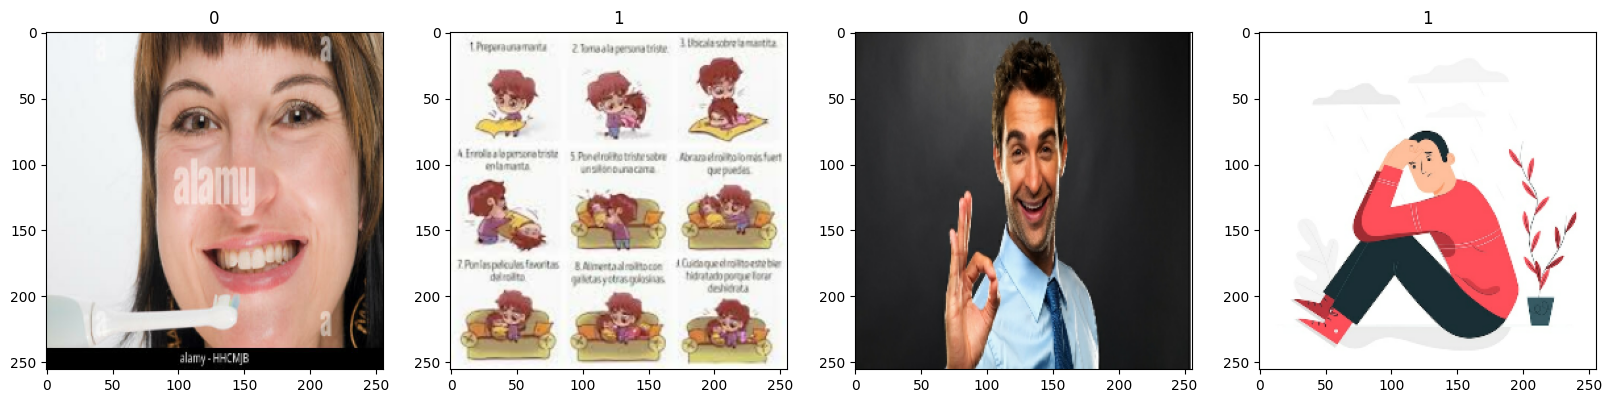

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [14]:
batch[0].max()

255.0

In [15]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()[0].max()

1.0

#### 2.2 Split Data

In [17]:
len(data)

6

In [18]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [19]:
train_size + val_size + test_size

6

In [20]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [21]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### 3. Deep Model

#### 3.1 Build Deep Learning Model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [23]:
model = Sequential()

In [24]:
#Define Model
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [25]:
#Define loss and optimizer
model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [27]:
#Fit the model
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 4s 171ms/step - loss: 1.5929 - accuracy: 0.5234 - val_loss: 0.9255 - val_accuracy: 0.5312
Epoch 2/20
4/4 [==============================] - 1s 125ms/step - loss: 0.8314 - accuracy: 0.4766 - val_loss: 0.8026 - val_accuracy: 0.5000
Epoch 3/20
4/4 [==============================] - 1s 128ms/step - loss: 0.7367 - accuracy: 0.5234 - val_loss: 0.7146 - val_accuracy: 0.3125
Epoch 4/20
4/4 [==============================] - 1s 139ms/step - loss: 0.6889 - accuracy: 0.5156 - val_loss: 0.6711 - val_accuracy: 0.7188
Epoch 5/20
4/4 [==============================] - 1s 130ms/step - loss: 0.6682 - accuracy: 0.6328 - val_loss: 0.6473 - val_accuracy: 0.7188
Epoch 6/20
4/4 [==============================] - 1s 145ms/step - loss: 0.6371 - accuracy: 0.7500 - val_loss: 0.6067 - val_accuracy: 0.6250
Epoch 7/20
4/4 [==============================] - 1s 128ms/step - loss: 0.6281 - accuracy: 0.6172 - val_loss: 0.5656 - val_accuracy: 0.8438
Epoch 8/20
4/4 [====

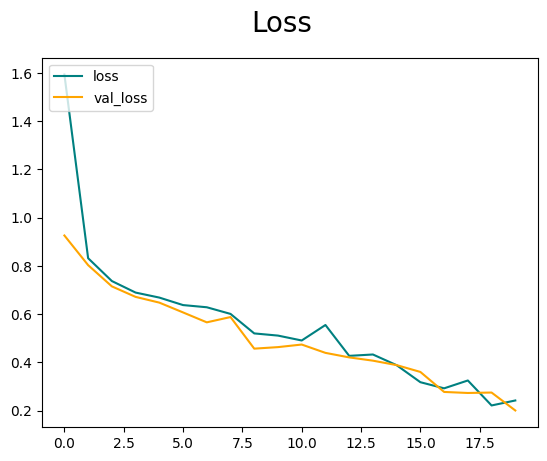

In [29]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

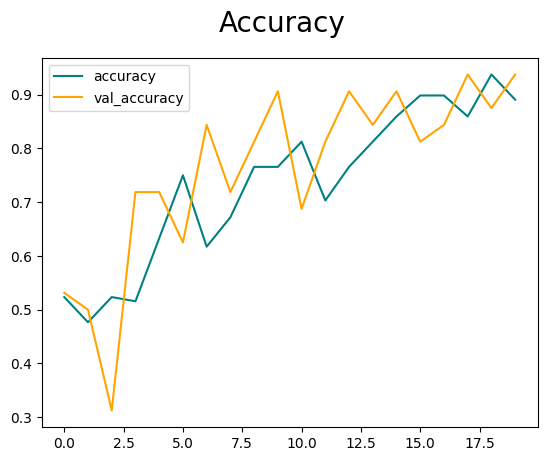

In [30]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

 ### 4. Evaluate Model

In [31]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [32]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [33]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    pred_y = model.predict(X)
    pre.update_state(y, pred_y)
    re.update_state(y, pred_y)
    acc.update_state(y, pred_y)

In [34]:
print(f'Precision:{pre.result()}, Recall: {re.result()}, BinaryAccuracy: {acc.result()}')

Precision:1.0, Recall: 1.0, BinaryAccuracy: 1.0


 ### 5. Test Model

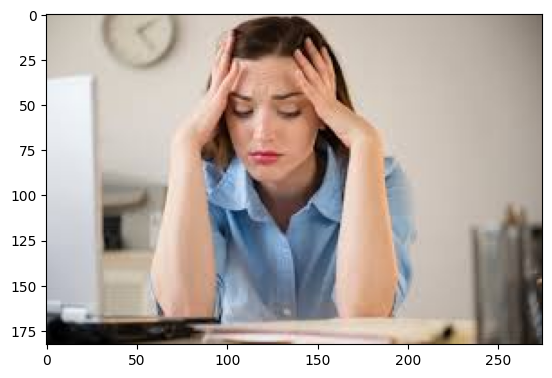

In [35]:
img = cv2.imread('sad_test.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

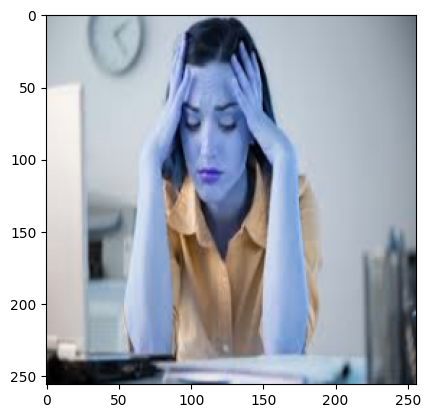

In [36]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [37]:
pred_y = model.predict(np.expand_dims(resize/255, 0))

In [38]:
pred_y

array([[0.35790783]], dtype=float32)

In [39]:
if pred_y > 0.5: 
    print(f'Predicted class is Happy')
else:
    print(f'Predicted class is Sad')

Predicted class is Sad
